# Week 4 lesson: Model evaluation
This week focuses on evaluation of the predictions made by machine learning compared to actual values

## 4.1 Evaluation Metrics: Session Overview

In [64]:
## Import the modules needed for the analys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import accuracy_score
from sklearn.metrics import mutual_info_score, accuracy_score, mean_squared_error

import seaborn as sns

%matplotlib inline

In [45]:
#!wget  'https://archive.ics.uci.edu/static/public/222/bank+marketing.zip'
!ls 
#!unzip bank+marketing.zip
#!unzip bank.zip
#!wget -O customer_churn.csv 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv'

bank+marketing.zip   bank-full.csv   bank.csv  customer_churn.csv
bank-additional.zip  bank-names.txt  bank.zip  week4Workbook.ipynb


In [46]:
## read in the data
df = pd.read_csv('customer_churn.csv')

In [47]:
## make all column names the same format
df.columns = df.columns.str.lower().str.replace(' ', '_')
## Make all values the same format (only strings values)
string_var = list(df.dtypes[df.dtypes == 'object'].index)
for var in string_var:
    df[var] = df[var].str.lower().str.replace(' ', '_')
df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)

In [48]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

y_train = df_train.churn.values
y_test = df_test.churn.values
y_val = df_val.churn.values

del df_train['churn']
del df_test['churn']
del df_val['churn']

In [49]:
numeric = ['tenure', 'monthlycharges','totalcharges' ]

categorical = ['gender', 'seniorcitizen', 'partner', 'dependents',
        'phoneservice', 'multiplelines', 'internetservice',
       'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
       'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling',
       'paymentmethod']

In [51]:
dv = DictVectorizer(sparse=False)

train_dicts = df_train[categorical + numeric].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

model = LogisticRegression()
model.fit(X_train, y_train)

/Users/saikouybah/mambaforge/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [52]:
val_dicts = df_val[categorical + numeric].to_dict(orient='records')
X_val = dv.transform(val_dicts)

y_pred = model.predict_proba(X_val)[:,1]
churn_decision = y_pred >0.5
(y_val == churn_decision).mean()


0.8026969481902059

## 4.2 Accuracy and dummy model
- Evaluate the model on different thresholds
- Check the accuracy of dummy baseline

 Acurarcy: *percentage of correct prediction*

In [53]:
len(y_val)

1409

In [55]:
(y_val == churn_decision).sum()

1131

In [56]:
1131/1409

0.8026969481902059

In [71]:
accuracy_score(y_val, y_pred >= 0.5)

0.8026969481902059

In [76]:
thresholds = np.linspace(0,1, 21)
scores =  []
for t in thresholds:
    score = accuracy_score(y_val, y_pred >= t)
    print('%.2f %.3f' %(t, score))
    scores.append(score)

0.00 0.274
0.05 0.510
0.10 0.592
0.15 0.667
0.20 0.710
0.25 0.738
0.30 0.760
0.35 0.772
0.40 0.785
0.45 0.793
0.50 0.803
0.55 0.801
0.60 0.795
0.65 0.786
0.70 0.766
0.75 0.744
0.80 0.735
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


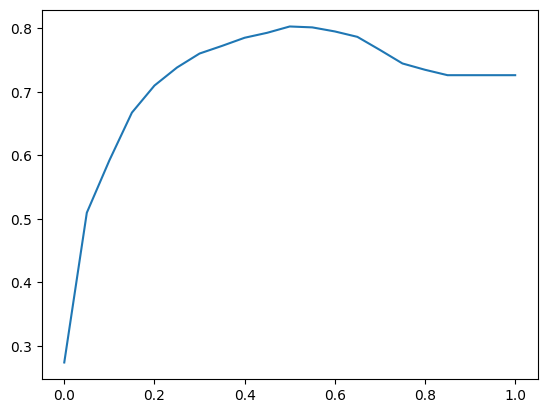

In [74]:
plt.plot(thresholds, scores)

In [78]:
from collections import Counter

In [79]:
Counter(y_pred >= 1.0)

Counter({False: 1409})

In [83]:
1 - y_val.mean()

0.7260468417317246

### 4.3 Confusion table (Matrix)
- Diffrent types of errors and correct decisions
- Arranging them in a table

In [84]:
acttual_postive = (y_val == 1)
acttual_negative = (y_val == 0)

In [87]:
t = 0.5
predict_postive = (y_pred >= t)
predict_negative = (y_pred < t)

In [92]:
tp = (predict_postive & acttual_postive).sum()
tn = (predict_negative & acttual_negative).sum()

In [100]:
fp = (predict_postive & acttual_negative).sum()
fn = (predict_negative & acttual_postive).sum()

In [103]:
confusion_matrix  = np.array([
    [tn,fp],
    [fn,tp]
])
confusion_matrix

array([[921, 102],
       [176, 210]])

In [106]:
(confusion_matrix/ confusion_matrix.sum()).round(2)

array([[0.65, 0.07],
       [0.12, 0.15]])

### 4.4 Precision and Recall

##### **Acuracy**
- How predictions are right

In [108]:
(tp+ tn) / (tp+tn+fn+fp)

0.8026969481902059

##### **Precision**
- How many (fraction of) positive predictions are correct
- Equal: TP/(TP + FP)

In [110]:
p = tp/(tp+fp)
p

0.6730769230769231

#### Recall
- Fraction of correctly indentified postive examples
- Equal: TP/(TP + FN)

In [113]:
r = tp/(tp+fn)
r

0.5440414507772021

### 4.5 ROC Curves


### TPR and FPR
##### False Positive rate (FPR)
- FPR = FP/(TN + FP)
##### True Negative rate (FNR)
- TNR = TP/(TP+TN)) 

In [114]:
trp = tp/(tp+fn)
trp

0.5440414507772021

In [119]:
frp = fp/(fp+tn)
frp

0.09970674486803519

In [137]:
scores = []
thresholds = np.linspace(0,1,101)

for t in thresholds:
    acttual_postive = (y_val == 1)
    acttual_negative = (y_val == 0)
    
    predict_postive = (y_pred >= t)
    predict_negative = (y_pred < t)
    
    tp = (predict_postive & acttual_postive).sum()
    tn = (predict_negative & acttual_negative).sum()

    fp = (predict_postive & acttual_negative).sum()
    fn = (predict_negative & acttual_postive).sum()
    scores.append((t, tp, fp, fn, tn))


In [152]:
columns = ['thresholds', 'tp', 'fp', 'fn', 'tn']
score_df = pd.DataFrame(scores, columns=columns)

In [153]:
score_df['tpr'] = score_df.tp / (score_df.tp + score_df.fn)
score_df['fpr'] = score_df.fp / (score_df.fp + score_df.tn)

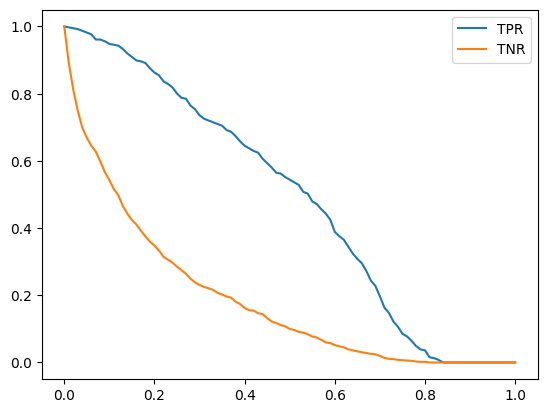

In [160]:
plt.plot(score_df.thresholds, score_df.tpr, label='TPR')
plt.plot(score_df.thresholds, score_df.fpr, label='TNR')
plt.legend()

#### Random model

In [161]:
np.random.seed(1)
y_rand = np.random.uniform(0,1, size=len(y_val))

In [162]:
y_rand

array([4.17022005e-01, 7.20324493e-01, 1.14374817e-04, ...,
       7.73916250e-01, 3.34276405e-01, 8.89982208e-02])

In [164]:
((y_rand >= 0.5) == y_val).mean()

0.5017743080198722

In [166]:
def trp_fpr_dataframe (y_val, y_pred):
    scores = []
    thresholds = np.linspace(0,1,101)

    for t in thresholds:
        acttual_postive = (y_val == 1)
        acttual_negative = (y_val == 0)
        
        predict_postive = (y_pred >= t)
        predict_negative = (y_pred < t)
        
        tp = (predict_postive & acttual_postive).sum()
        tn = (predict_negative & acttual_negative).sum()
    
        fp = (predict_postive & acttual_negative).sum()
        fn = (predict_negative & acttual_postive).sum()
        scores.append((t, tp, fp, fn, tn))

    columns = ['thresholds', 'tp', 'fp', 'fn', 'tn']
    score_df = pd.DataFrame(scores, columns=columns)
    score_df['tpr'] = score_df.tp / (score_df.tp + score_df.fn)
    score_df['fpr'] = score_df.fp / (score_df.fp + score_df.tn)

    return score_df


In [168]:
df_rand = trp_fpr_dataframe(y_val, y_rand)

In [169]:
df_rand[::10]

,thresholds,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,347,923,39,100,0.898964,0.902248
20,0.2,307,822,79,201,0.795337,0.803519
30,0.3,276,724,110,299,0.715026,0.707722
40,0.4,237,624,149,399,0.613990,0.609971
50,0.5,202,518,184,505,0.523316,0.506354
60,0.6,161,409,225,614,0.417098,0.399804
70,0.7,121,302,265,721,0.313472,0.295210
80,0.8,78,206,308,817,0.202073,0.201369
90,0.9,40,101,346,922,0.103627,0.098729


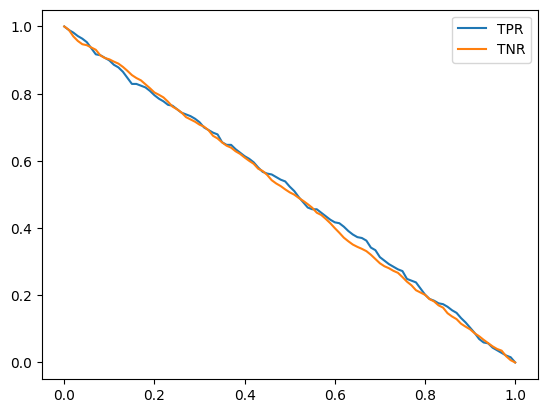

In [170]:
plt.plot(df_rand.thresholds, df_rand.tpr, label='TPR')
plt.plot(df_rand.thresholds, df_rand.fpr, label='TNR')
plt.legend()